In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models # this models contains all the highly pretrained models.

Initialize GPU

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Clone the git repo for getting our dataset

In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 51.69 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls

ants_and_bees  sample_data


In [5]:
!ls ants_and_bees

train  val


In [6]:
!ls ants_and_bees/train

ants  bees


Apply transform and augmentation on our images

In [0]:
transform_train = transforms.Compose([transforms.Resize((224,224)), #We resize our data as vgg16 is trained on 224*224 size images
                                      transforms.RandomHorizontalFlip(), # flips the image at horizontal axis
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1), # We can change it according to the accuracy and requirements
                                      transforms.ToTensor(), # convert the image to tensor to make it work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [9]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


Convert the images in order to plot them using plt

In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ('ant', 'bee') # since our dataset has 2 classes

Iter our data to plot our images. 

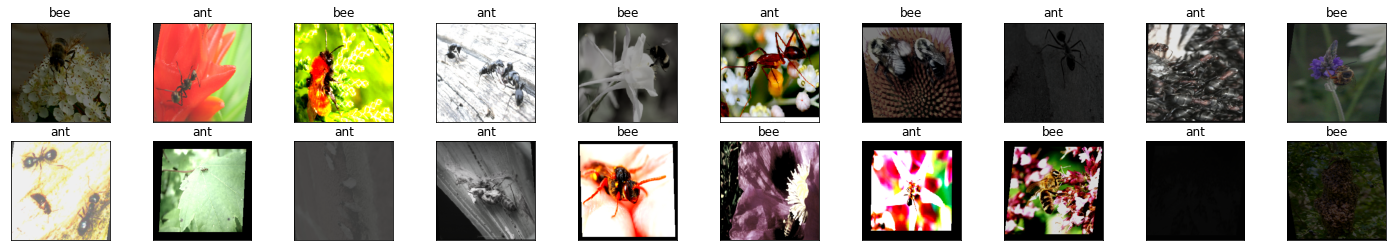

In [13]:
dataiter = iter(training_loader) # converting our train folder to iterable so that it can be iterated through a batch of 20.
images, labels = dataiter.next() # We get our inputs for our model here.
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

We define our model here. We are using vgg16 here which has 16 layers

In [14]:
model = models.vgg16(pretrained=True) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [15]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Here we are freezing the feature parameters and using same as in vgg16. These parameters are very good as this model is trained on 14 million images for 2 weeks with many GPUs
for param in model.features.parameters():
  param.requires_grad = False # the feature layers do not require any gradient.

In [17]:
#We take the last fully connected layer from vgg16 and replace it with our layer as we need to classify only 2 different categories
import torch.nn as nn

n_inputs = model.classifier[6].in_features # the i/p features of our classifier model
last_layer = nn.Linear(n_inputs, len(classes))  # new layer that we want to put in there.
model.classifier[6] = last_layer  # replacing last layer of vgg16 with our new layer
model.to(device)  # Put the model in device for higher processing power
print(model.classifier[6].out_features)

2


In [0]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy from keras
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) #lr is very low as we have a very samll dataset

# Fitting our model with our inputs and displaying the progress.

In [19]:
epochs = 5 # lesser epochs as our dataset is small
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader: #taking inputs and put it in our model which is inside device
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset) # We are now dividing the total loss of one epoch with the enitre length of dataset to get the probability between 1 & 0
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0290, acc 0.7377 
validation loss: 0.0135, validation acc 0.8954 
epoch : 2
training loss: 0.0171, acc 0.8279 
validation loss: 0.0115, validation acc 0.9150 
epoch : 3
training loss: 0.0145, acc 0.8811 
validation loss: 0.0120, validation acc 0.9281 
epoch : 4
training loss: 0.0125, acc 0.9057 
validation loss: 0.0165, validation acc 0.9085 
epoch : 5
training loss: 0.0116, acc 0.8852 
validation loss: 0.0154, validation acc 0.9020 


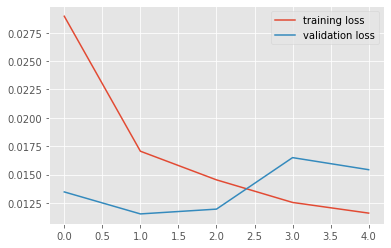

In [22]:
plt.style.use("ggplot")
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

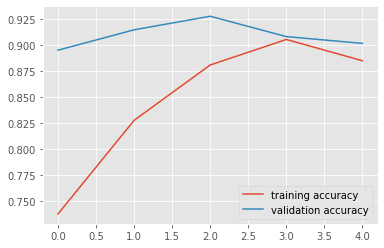

In [21]:
plt.style.use("ggplot")
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

# We now plot new images from web and try to predict them using our model

In [0]:
import PIL.ImageOps  # # from python imaging library we take this so we can preform operations on our image

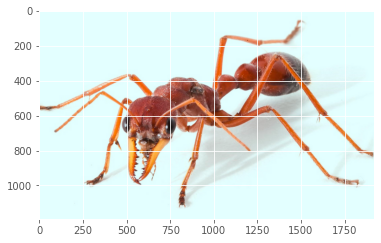

In [24]:
import requests
from PIL import Image

url = 'http://cdn.sci-news.com/images/enlarge5/image_6425e-Giant-Red-Bull-Ant.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

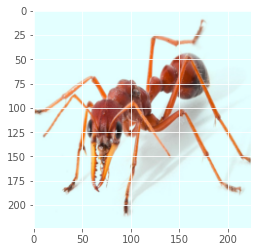

In [25]:
img = transform(img)  # transform before i/p to our model.
plt.imshow(im_convert(img)) #converting the image to plot using plt

Prediction:

In [26]:
image = img.to(device).unsqueeze(0) # unsqueeze to add one dimension
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


Test our model using random images from our validation dataset.

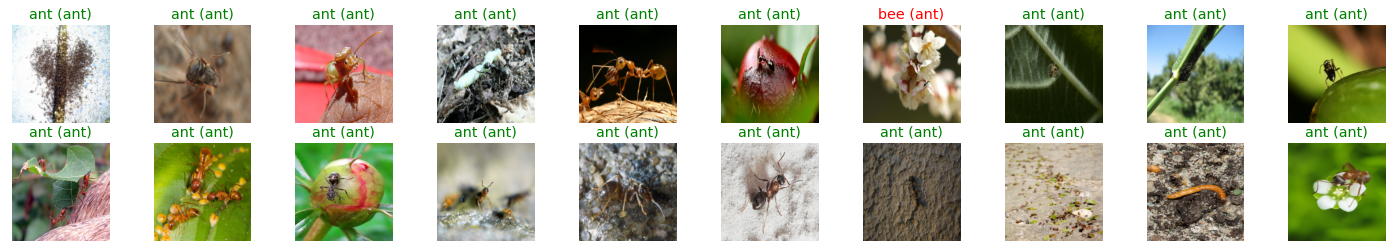

In [27]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [0]:
# Our model has performed really well using transfer learning